In [318]:
%load_ext line_profiler
import networkx as nx
from pyvis.network import Network
import pandas as pd 
from pythonds3.basic import Queue, Stack
from pythonds3.trees import PriorityQueue
import string
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from timeit import Timer
from functools import partial
import sys 
import numpy as np

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## Discussion Questions

In [3]:
""" 
1. Draw the graph corresponding to the following adjacency matrix.
"""

def G_from_adjacency_matrix(matrix, node_names):
    #if there is directionality, then we assume the rows are source nodes,
    #and cols are target nodes 
    assert len(matrix) == len(node_names)
    G = nx.MultiDiGraph()

    for row in range(len(matrix)):
        for col in range(len(matrix[row])):
            if matrix[row][col] is not None:
                G.add_edge(node_names[row], node_names[col], weight=matrix[row][col])
    return G

def visualise_nx_graph(graph, directed=True, multi_edge=True, graph_name=None,
show_edge_weights=True):
    assert graph_name is not None and '.html' in graph_name
    net = Network(notebook=True, directed=directed)
    if multi_edge:
        net.set_edge_smooth('dynamic')
    net.from_nx(graph, show_edge_weights=show_edge_weights)
    net.show(graph_name)

adjacencyMatrix = [
    [None, 7, 5, None, None, 1],
    [2, None, None, 7, 3, None],
    [None, 2, None, None, None, 8],
    [1, None, None, None, 2, 4],
    [6, None, None, 5, None, None],
    [None, 1, None, None, 8, None]
]

#need to set net to directed and set_edge_smooth to dynamic to enable multiple edges between nodes

net_d1 = Network(notebook=True, directed=True)
G = G_from_adjacency_matrix(adjacencyMatrix, string.ascii_uppercase[:6])

visualise_nx_graph(G, graph_name='disc_q1.html')

In [4]:
"""
2. Draw the graph corresponding to the following list of edges.
"""

G = nx.MultiDiGraph()
edges = [(1, 2, 10),
        (1, 3, 15),
        (1, 6, 5),
        (2, 3, 7),
        (3, 4, 7),
        (3, 6, 10),
        (4, 5, 7),
        (6, 4, 5),
        (5, 6, 13)]

for edge in edges:
    G.add_edge(edge[0], edge[1], weight=edge[2])

visualise_nx_graph(G, graph_name='disc_q2.html', show_edge_weights=False,
directed=True)


In [375]:
"""
3. Ignoring the weights, perform a breadth first search on the graph from the previous question

    - implementing bfs from scratch using networkx graph object as an alternative way of answering the question
"""

def bfs_nx(g, start_node=None):
    assert start_node in list(g)
    #set_node_attributes: if nodes not specified, then applies to all nodes
    nx.set_node_attributes(g, 0, 'explore_status')
    nx.set_node_attributes(g, 0, 'distance')
    nx.set_node_attributes(g, None, 'predecessor')
    explore_queue = Queue()
    explore_queue.enqueue(start_node)
    while not explore_queue.is_empty():
        current_node = explore_queue.dequeue()
        #only keep neighbours that are unexplored 
        neighbours = [neigh for neigh in list(g[current_node]) if g.nodes[neigh]['explore_status'] == 0]
        for neigh in neighbours:
            #we set exploration status to 1 - indicating that we've visited this node before, and predecessor 
            nx.set_node_attributes(g, {neigh: {'explore_status': 1, 
                                            'predecessor': current_node,
                                            'distance': g.nodes[current_node]['distance'] + 1}})
            explore_queue.enqueue(neigh)
    
        nx.set_node_attributes(g, {current_node: {'explore_status': 2}})
    

def bfs_predecessors_nx(g, start_node):
    bfs_nx(g, start_node=start_node)
    predecessors = []
    for node in list(g):
        if node != start_node:
            predecessors.append((node, g.nodes[node]['predecessor']))
    
    return predecessors

In [376]:
#test bfs implementation
n_trials = 100
for _ in tqdm(range(n_trials)):
    n_nodes = random.randint(10, 50)
    p = random.uniform(0.5, 0.9)
    random_graph = nx.gnp_random_graph(n_nodes, p=p)
    assert sorted(list(nx.bfs_predecessors(random_graph, 1))) == sorted(bfs_predecessors_nx(random_graph, 1))

100%|██████████| 100/100 [00:00<00:00, 392.82it/s]


4. What is the Big-O running time of the buildGraph function? 

```python
def buildGraph(wordFile):
    d = {}
    g = Graph()
    wfile = open(wordFile,'r')
    # create buckets of words that differ by one letter
    for line in wfile:
        word = line[:-1]
        for i in range(len(word)):
            bucket = word[:i] + '_' + word[i+1:]
            if bucket in d:
                d[bucket].append(word)
            else:
                d[bucket] = [word]
    """
    in this step, O(k*n) where k = 4 in this instance b/c length of words is 4. 
    """

    # add vertices and edges for words in the same bucket
    for bucket in d.keys():
        for word1 in d[bucket]:
            for word2 in d[bucket]:
                if word1 != word2:
                    g.addEdge(word1,word2)

    """
    The maximum number of words in a bucket is 26, and theoretical upper bound of the number of buckets is 
    26^(k-1). So the theoretical maximum number of edges added is 26^k (from 26 * 26^(k-1))
    But, of course majority of the letter combinations will not be words... and this considers ALL possible k letter word combinations 
    which is overkill.

    If we consider the input size (5110 words in this case), 
    if we take n/26 = ~197, we get the minimum possible number of buckets.
    This assumes the case where the word list perfectly segments into buckets of 26 words (WORSE case, but pretty much impossible b/c again, 
    most combinations won't be words). 
    in this case, we will need to create 197 * (26 * 25) = 133,172 edges (theoretical maximum of edges needed in this scenario - in the actual
    buildGraph output there were only ~53,000 edges)

    so, combining the two processes:
    O(k*n) + O(n/26 * 26 * 25) -> O(k*n + (n * 25)) -> O(n(k + 1))

    ^ this is just my thinking of the process... because I suppose this is a particular case where we can identify an upper bound to the number of 
    edges quite easily, and so was trying to think of it in a different way, where we can quantify the coefficients.
    But the answer to the question is really just O(n^2) b/c the second 
    process involves two nested for loops that, which essentially always comes to n * (n-1) = n^2 - n operations, it's just that the 
    coefficient would differ based on the average number of words in each bucket (e.g. for the sample problem the coefficient would be
    0.002. AND in theory as n increases the coefficient no longer matters, but you know number of words is a pretty finite problem so)
    """    

    return g

```


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


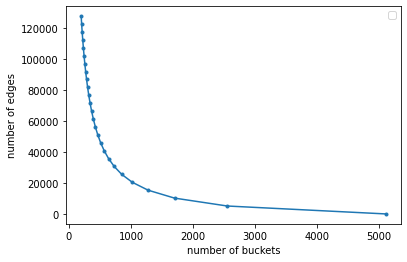

In [7]:
"""
Question 4. additional proof just to make sure my assumptions are correct in my own derivation... 
if the number of buckets increase, ie. the average number of words within each number decreases, the 
theoretical total possible number of edges added will also decrease.
"""

x = 5110
X = []
Y = []
for n_words in range(26, 0, -1):
    n_buckets = x/n_words 
    X.append(n_buckets)
    Y.append(n_buckets * (n_words * (n_words-1)))



plt.plot(X, Y, marker='.')

plt.xlabel('number of buckets')
plt.ylabel('number of edges')
plt.legend()


100%|██████████| 50/50 [00:00<00:00, 103563.06it/s]


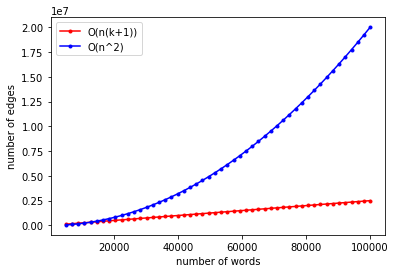

In [8]:
"""
Question 4. just wanted to have a look and compare the big-O that I derived and a straightforward n^2
- we naively assume that the coefficient is 0.002 for O(n^2) from the previous example
- we're just assuming the minimum number of buckets is obtained for each x, to maximise the number of edges
that are obtained
"""

X = np.linspace(5000, 100_000)
Y1 = []
Y2 = []
n_words_per_bucket = 26
for x in tqdm(X):
    n_buckets = x/n_words_per_bucket
    Y1.append(n_buckets * (n_words_per_bucket * (n_words_per_bucket-1)))
    Y2.append(0.002 * x**2)


plt.plot(X, Y1, marker='.', color='red', label='O(n(k+1))')
plt.plot(X, Y2, marker='.', color='blue', label='O(n^2)')


plt.xlabel('number of words')
plt.ylabel('number of edges')
plt.legend()



5.Derive the Big-O running time for the topological sort algorithm.


***
1. Call dfs(g) for some graph g. The main reason we want to call depth first search is to compute the finish times for each of the vertices.
***
    Time complexity of dfs is O(V + E)
***


2. Store the vertices in a list in decreasing order of finish time.
***
    We can store vertices during dfs; the main insight is that dfs always arrives at the final 
    node in the dfs tree first, and completes it, then goes back to complete the previous nodes. 
    Again, b/c dfs is a recursive function, it essentially is serving as a stack that pushes out 
    nodes as they "finish". So, during DFS, we simply need to append the finished nodes into self.finish_order
    to obtain an ordered list of nodes with increasing finishing times.
    We then return the reversed list (or we can list.insert(0, node) during dfs if we wish) as the result for topological sort.
    So this step does not increase the time complexity of that of dfs!
***

3. Return the ordered list as the result of the topological sort.
***
    Here we just need to reverse the list, which is an O(V) operation
***

Combining the big-O if the two operations:
***
    O(V+E) + O(V) -> O(V+E)
***


In [192]:
class Base_NX:
    def __init__(self, g, check_graph=False):
        self._g = g 
        self.check_graph = check_graph

    def set_node_attribute(self, g, vertex=None, key=None, val=None):
        if vertex is None:
            #if no vertex is specified then we just set it for all nodes
            nx.set_node_attributes(g, val, key)
        else:
            assert vertex in list(g)
            nx.set_node_attributes(g, {vertex: {key: val}})

    def get_node_attribute(self, g, vertex, key):
        assert vertex in list(g)
        return g.nodes[vertex][key]

    def get_out_edges(self, vertex, data=True):
        if not nx.is_directed(self._g):
            return list(self._g.edges(vertex, data=data))
        else:
            return list(self._g.out_edges(vertex, data=data))

    def check_graph(self):
        raise NotImplementedError()

#add an animate function here?
        

In [311]:
#implentation of Q5 topological sort

class TopologicalSort_NX(Base_NX):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._topological_finish_order = Stack()
        self.time = 0
        self._explore_status = {}
        self._predecessors = {}
        self._discovery_time = {}
        self._finish_time = {}
        self._out_edges = {}

    def check_graph(self):
        if self._g is None:
            raise Exception('no networkx graph object stored')
        if not nx.is_directed_acyclic_graph(self._g):
            raise Exception('graph is not a DAG.')

    def initialize_topologicalSort_parameters(self, g):
        self._explore_status = {}
        self._predecessors = {} 
        self._discovery_time = {}
        self._finish_time = {}
        self._out_edges = {}
        for node in iter(self._g):
            self._explore_status[node] =  0
            self._predecessors[node] = None 
            self._discovery_time[node] = -1
            self._finish_time[node] = -1
            self._out_edges[node] = tuple(g.out_edges(node))

    def _topological_dfs(self):
        if self.check_graph:
            self.check_graph()

        #reset parameters
        self.time = 0
        self._topological_finish_order = []
        self.initialize_topologicalSort_parameters(self._g)


        for vertex in list(self._g):
            if self._explore_status[vertex] == 0:
                self._topological_dfsVisit(self._g, vertex, self._topological_finish_order)


    def _topological_dfsVisit(self, g, start_vertex, finish_order):
        self.time += 1
        self._explore_status[start_vertex] = 1
        self._discovery_time[start_vertex] = self.time

        #not going through NEIGHBOURS!!! going through CHILDREN
        for _, child in self._out_edges[start_vertex]:
            if self._explore_status[child] == 0:
                self._explore_status[child] = 1
                self._predecessors[child] = start_vertex
                self._topological_dfsVisit(g, child, finish_order)
        
        self.time += 1
        #finish node exploration
        self._finish_time[start_vertex] = self.time
        self._explore_status[start_vertex] = 2
        #here we append the finished vertex to self.order for topologicalSort
        #check that the finishing time for this node is larger than the latest entry in finish_order
        # if len(finish_order):
        #     last = self.get_node_attribute(g, vertex=finish_order[-1], key=TopologicalSort_NX.__finish_time__)
        #     curr = self.get_node_attribute(g, vertex=start_vertex, key=TopologicalSort_NX.__finish_time__)
        #     assert last < curr
        finish_order.append(start_vertex)

    
    def topologicalSort(self):
        self._topological_dfs()
        return self._topological_finish_order[::-1]
        



In [312]:
class GraphGenerator_Base:
    def __init__(self, min_n=10, max_n=100, min_p=0.25, max_p=0.75, 
                directed=True, weighted=True, min_weight=1, max_weight=10,
                is_connected=True):
        self.min_n = min_n
        self.max_n = max_n 
        self.min_p = min_p
        self.max_p = max_p 
        self.is_directed = directed 
        self.is_weighted = weighted
        self.min_weight = min_weight 
        self.max_weight = max_weight 
        self.is_connected = is_connected

        assert max_n > min_n and min_n > 0
        assert max_p > min_p and max_p <= 1
        assert max_weight > min_weight 

    def generate_n(self):
        return random.randint(self.min_n, self.max_n)

    def generate_p(self):
        return random.uniform(self.min_p, self.max_p)

    def generate_g(self):
        g = nx.gnp_random_graph(self.generate_n(), self.generate_p(), directed=self.is_directed)
        if self.is_connected and not self.is_directed:
            while not nx.is_connected(g):
                g = nx.gnp_random_graph(self.generate_n(), self.generate_p(), directed=self.is_directed)
            return g
        else:
            return g

    def generate_weight(self):
        return {'weight': random.randint(self.min_weight, self.max_weight)}

    def generate_graph(self):
        raise NotImplementedError()


In [313]:
class DAG_Generator(GraphGenerator_Base):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def generate_graph(self):
        g = self.generate_g()

        if self.is_weighted:
            DAG = nx.MultiDiGraph([(u, v, self.generate_weight()) for (u,v) in g.edges() if u < v])
        else:
            DAG = nx.MultiDiGraph([(u, v) for (u,v) in g.edges() if u < v])

        assert nx.is_directed_acyclic_graph(DAG)
        return DAG

In [314]:
#test Topological sort implementation 

def topological_sort_check(graph, res, mode='vertex'):
    """
    Topological sort definition:
    an ordering of the nodes such that for every edge (u,v) in G,
    u appears earlier than v in the ordering

    - edge and vertex modes look at the same thing, just examining it from a different perspective
    """

    if mode == 'vertex':
        """
        vertex mode:
        we iterate through the vertices from the sort.
        At each vertex we look at the outgoing edges. If the target of any outgoing edges precedes the 
        vertex in the ordering, then the sort result is invalid!

        time complexity: O(V^2 * E)
        """
        for i,node in enumerate(res):
            preceding = res[:i]
            out_edges = graph.out_edges(node)
            for _, target in out_edges:
                if target in preceding:
                    return False 
    elif mode == 'edge':
        """
        edge mode:
        we look at all the edges in G. for each edge, we get the index of its vertex
        within the ordering. If the origin vertex isn't earlier than the target vertex,
        then the ordering is invalid!
        - here it's important that the graph is a DAG, because or else there will exist edges 
        that point from a later ordering back to an earlier vertex
        - BASICALLY the definitin of topological ordering (look above)

        time complexity: O(E*V)
        """
        edges = list(graph.edges())
        for source, target in edges:
            source_idx = res.index(source)
            target_idx = res.index(target)
            if source_idx > target_idx:
                return False

    elif mode == 'finish_time':
        """
        just checks that the finish_time is in decreasing order as a way of validating the results
        """
        prev = None
        for node in res:
            curr = graph.nodes[node]['finish_time']
            if prev is not None:
                if prev < curr:
                    return False 
            prev = curr 

    return True

                    

n_trials = 100
generator = DAG_Generator()
for _ in tqdm(range(n_trials)):
    dag = generator.generate_graph()
    ts = TopologicalSort_NX(dag)
    res = ts.topologicalSort()
    assert topological_sort_check(ts._g, res, mode='edge')



100%|██████████| 100/100 [00:01<00:00, 55.42it/s]


6.Derive the Big-O running time for the strongly connected components algorithm.

1. Call dfs for the graph  to compute the finish times for each vertex.

***
    Time complexity of dfs is O(V+E)
***

2. Compute G<sup>T</sup>
***
    Time complexity of the transpose computation is O(E) (b/c we're just flipping every edge)
***

3. Call dfs for the graph  but in the main loop of DFS explore each vertex in decreasing order of finish time.
***
    Time complexity of dfs is O(V+E) again. As for exploring each vertex in decreasing order of finish time in the main loop,
    we can store the vertices from the first dfs as we do in topologicalsort, so obtaining this list would just be a matter iterating in reverse over of the saved list, which wouldn't add to the time complexity.
***

4. Each tree in the forest computed in step 3 is a strongly connected component. Output the vertex ids for each vertex in each tree in the forest to identify the component.
***
    Outputting the vertex ids for each vertex in each tree can be incorporated into the second dfs, where in the main loop we can keep track
    of the current tree, appending nodes within the nested dfs calls. When a new node is explored in the main loop, we start a new tree to 
    keep track of. So this operation does not add additional time complexity.
***

Combining everything:
***
    O(V+E) + O(E) + O(V+E) -> O(V+E)
***


In [315]:
#Implementation of the SCC algorithm

class SCC_NX(TopologicalSort_NX):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._gT = None
        self._scc_trees = []

    def _transpose_graph(self):
        if self._g is None:
            raise Exception('no graph object stored')
        #reverse direction of edges
        self._gT = nx.MultiDiGraph([(target, source) for (source, target) in tuple(self._g.edges())])

    def check_graph(self):
        if self._g is None:
            raise Exception('no networkx graph object stored')
        if not nx.is_directed(self._g):
            raise Exception('graph is not directed!')

    def _scc_dfs(self):
        if self._gT is None:
            raise Exception('no gT stored')
        #reset parameters
        self.time = 0
        self._scc_finish_order = []
        self._scc_trees = []
        self.initialize_topologicalSort_parameters(self._gT)

        #the key difference here is just that we're iterating through the list of nodes in 
        #decreasing finishing time from the first dfs
        #here also we save the trees created during dfs!
        curr_tree = []
        for vertex in self._topological_finish_order[::-1]:
            if self._explore_status[vertex] == 0:
                if len(curr_tree):
                    self._scc_trees.append(curr_tree)
                curr_tree = []
                self._scc_dfsVisit(self._gT, vertex, curr_tree)

        if len(curr_tree):
            self._scc_trees.append(curr_tree)

    def _scc_dfsVisit(self, g, start_vertex, curr_tree):
        self.time += 1
        self._explore_status[start_vertex] = 1
        self._discovery_time[start_vertex] = self.time

        #adding current node to curr_tree
        curr_tree.append(start_vertex)

        #Here we are only extracting the out edges!
        for _, child in self._out_edges[start_vertex]:
            if self._explore_status[child] == 0:
                self._explore_status[child] = 1
                self._predecessors[child] = start_vertex
                self._scc_dfsVisit(g, child, curr_tree)

        self.time += 1
        #finish node exploration
        self._finish_time[start_vertex] = self.time
        self._explore_status[start_vertex] = 2
                

    def StronglyConnectedComponents(self):
        self.topologicalSort()
        self._transpose_graph()
        self._scc_dfs()
        return self._scc_trees


In [308]:
class RandomGraph_Generator(GraphGenerator_Base):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def generate_graph(self):
        base = self.generate_g()
        if self.is_directed:
            if self.is_weighted:
                g = nx.MultiDiGraph([(u,v, self.generate_weight()) for u,v in base.edges()])
            else:
                g = nx.MultiDiGraph([(u,v) for u,v in base.edges()])
        else:
            if self.is_weighted:
                g = nx.MultiGraph([(u, v, self.generate_weight()) for u,v in base.edges()])
            else:
                g = nx.MultiGraph([(u,v) for u,v in base.edges()])
        return g

In [309]:
def check_scc(res, g):
    #transform sets into list 
    ans = sorted([list(scc) for scc in list(nx.strongly_connected_components(g))])
    if ans == sorted([sorted(r) for r in res]):
        return True 
    else:
        return False


n_trials = 100
generator = RandomGraph_Generator(min_n=10, max_n=100, min_p=0.25, max_p=0.75, weighted=False,
                                directed=True)
for _ in tqdm(range(n_trials)):
    g = generator.generate_graph()
    scc = SCC_NX(g)
    res = scc.StronglyConnectedComponents()
    assert check_scc(res, g)

    


100%|██████████| 100/100 [00:06<00:00, 14.90it/s]


In [155]:
"""
7. Show each step in applying Dijkstra’s algorithm to the graph shown above.

- we will just implement Dijkstra's algorithm for nx graphs as an answer 
"""

class Dijkstra_NX(Base_NX):

    def __init__(self, *args, **kwargs):
        """
        Main feature of this algo is the priorityQueue, where we always explore the current available
        shortest path ie. the dequeue operation from the priority queue! This is an example of a greedy algorithm, because we assume that for example 
        a -> b -> c, that the shortest path from a -> b will lead us to the solution to the shortest 
        path for a -> c (solving subproblems to solve the global problem)
        
        """
        super().__init__(*args, **kwargs)
        self._queue = PriorityQueue()
        self._dist = {}
        self._pred = {}


    def enqueue(self, vert):
        dist = self._dist[vert]
        self._queue.insert((dist, vert))

    def dequeue(self):
        return self._queue.delete()

    def initialize_parameters(self, start_node):
        self._dist = {}
        self._pred = {}
        for node in tuple(self._g):
            if node != start_node:
                self._dist[node] = sys.maxsize
            else:
                self._dist[node] = 0
            self._pred[node] = None

    def dijkstra(self, start_node):
        #check that the graph has a 'weight' attribute for edges 
        if self.check_graph:
            self.check_graph()
        #set starting parameters
        self.initialize_parameters(start_node)
        self.enqueue(start_node)
        while not self._queue.is_empty():
            curr_dist, current = self.dequeue()
            edges = self.get_out_edges(current)
            for _, neigh, data in edges:
                #get new dist of current neighbour
                weight = data['weight']                
                if weight < 0:
                    raise Exception('Negative edge weight found.')
                new_dist = curr_dist + weight
                neigh_dist = self._dist[neigh]
                if new_dist < neigh_dist:
                    self._pred[neigh] = current 
                    self._dist[neigh] = new_dist
                    if neigh in self._queue:
                        self._queue.change_priority(neigh, new_dist)
                    else:
                        self.enqueue(neigh)

    def shortest_path(self, target_node):
        """returns the shortest path from source node and the path length in a tuple"""
        n_nodes = self._g.number_of_nodes()
        i = 0
        path = []
        curr_node = target_node
        while curr_node is not None and i <= n_nodes:
            path.append(curr_node)
            curr_node = self._pred[curr_node]
            i += 1 
        
        if i > n_nodes:
            raise Exception('Path length is greater than number of nodes.')

    
        total_dist = self._dist[target_node]
        if total_dist == sys.maxsize:
            #there is no path towards target node
            return None

        return (path[::-1], total_dist)


    def check_graph(self):
        if self._g is None:
            raise Exception('No graph data stored!')
        edges = list(self._g.edges(data=True))
        if 'weight' not in edges[0][2]:
            raise Exception('Graph edges are not weighted!')


        



In [378]:
#test dijkstra implementation
def check_dijkstra(res, ans, target_node):
    """
    if range between min and max weight is too small, we can encounter multiple possible shortest paths,
    and so the answer generated might not be the same as nx's dijkstra implementation, so in the check
    we allow for that difference and as long as the shortest path length is the same we accept it
    """
    if res is None:
        assert target_node not in ans[0]
        print('No path to node.')
        return True
    else:
        path_correct = True 
        length_correct = True 

        if res[0] != ans[1][target_node]:
            print(res[0], ans[1][target_node])
            path_correct = False 
        if res[1] != ans[0][target_node]:
            print(res[1], ans[0][target_node])
            length_correct = False

        if not path_correct and length_correct:
            print('Different shortest path, but same length.')
            return True
        elif not path_correct and not length_correct:
            print('Different path and different length.')
            return False
        elif path_correct and length_correct:
            return True

n_trials = 100
generator = RandomGraph_Generator(min_n=10, max_n=100, min_p=0.25,
                                max_p=0.75, weighted=True, min_weight=1, max_weight=1000, 
                                directed=True)

for _ in tqdm(range(n_trials)):
    g = generator.generate_graph()
    dijkstra = Dijkstra_NX(g)
    start_node = random.choice(list(g))
    ans = nx.single_source_dijkstra(g, start_node)
    dijkstra.dijkstra(start_node=start_node)
    for target_node in list(g):
        #by checking the shortest path for every node we check the solutions
        #for each sub problem, ensuring that we get the right global answer as well
        res = dijkstra.shortest_path(target_node)
        assert check_dijkstra(res, ans, target_node)

        


100%|██████████| 100/100 [00:07<00:00, 14.27it/s]


In [269]:
""" 
8. Using Prim’s algorithm, find the minimum weight spanning tree for the graph shown above.
- we will implement it for NX graphs as an answer.
"""

class Prims_NX(Base_NX):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._queue = PriorityQueue()
        self._mst = []
        self._edges = {}
        self._min_edge = {}
        self._min_weight = {}
        self._in_tree = {}

    def enqueue(self, vert):
        weight = self._min_weight[vert]
        self._queue.insert((weight, vert))

    def dequeue(self):
        return self._queue.delete()

    def initialize_parameters(self, start_node):
        self._min_edge = {}
        self._min_weight = {}
        for node in tuple(self._g):
            self._min_edge[node] = None 
            self._min_weight[node] = sys.maxsize
            self._edges[node] = tuple(self._g.edges(node, data=True))
            self._in_tree[node] = False 
        self._min_weight[start_node] = 0

    def get_edge_weight(self, source, target):
        return self._g[source][target][0]['weight']

    def update_priorities(self, curr_node):
        #update all priorities here based on the new node that is added to the mst 
        neighs = tuple(self._g[curr_node])
        for neigh in neighs:
            edge_weight = self.get_edge_weight(curr_node, neigh)
            if self._min_weight[neigh] == sys.maxsize:
                self._min_weight[neigh] = edge_weight 
                self._min_edge[neigh] = (curr_node, neigh)
                self.enqueue(neigh)
            elif (edge_weight < self._min_weight[neigh]) and not self._in_tree[neigh]:
                self._min_weight[neigh] = edge_weight 
                self._min_edge[neigh] = (curr_node, neigh)
                self._queue.change_priority(neigh, edge_weight)
            

    def mst(self, return_weighted=True):
        """
        http://www.inf.ed.ac.uk/teaching/courses/ads/Lects/lecture14.15.pdf
        In my original implementation, during initialization we enqueue ALL the nodes into the queue, which 
        seems to be more inefficient. Instead, the better method is to enqueue neighbour nodes AS WE GO (enqueuing only 
        if it's not included into the tree yet.) This reduces the work during the update_priorities method!
        """
        if self.check_graph:
            self.check_graph()
        #for all nodes, initialize the starting parameters 
        start_node = random.choice(tuple(self._g))
        self.initialize_parameters(start_node)
        self.enqueue(start_node)

        while not self._queue.is_empty():
            weight, next = self.dequeue()
            self._in_tree[next] = True
            self.update_priorities(next)
            if next != start_node:
                min_edge = self._min_edge[next]
                if return_weighted:
                    self._mst.append((min_edge[0], min_edge[1], {'weight': weight}))
                else:
                    self._mst.append(min_edge)

        return self._mst


    def check_graph(self):
        #weighted, undirected graph
        if self._g is None:
            raise Exception('No graph data stored!')

        edges = list(self._g.edges(data=True))
        if 'weight' not in edges[0][2]:
            raise Exception('Graph edges are not weighted!')
        
        if nx.is_directed(self._g):
            raise Exception('Graph must be undirected.') 

        if not nx.is_connected(self._g):
            raise Exception('Graph is not connected.')

        

In [270]:
class UniqueWeightsGraph_Generator(GraphGenerator_Base):
    #just to provide another check to prims - using unique weights we should always arrive 
    #at the same solution (same tree and same weight)
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def generate_graph(self):
        base = self.generate_g()
        if not self.is_weighted:
            raise Exception('Edges must be weighted.')

        weights = list(range(len(base.edges())))
        random.shuffle(weights)

        if self.is_directed:
            g = nx.MultiDiGraph([(u,v, {'weight': w}) for (u,v), w in zip(base.edges(), weights)])
        else:
            g = nx.MultiGraph([(u, v, {'weight': w}) for (u,v), w in zip(base.edges(), weights)])

        return g
        

In [271]:
def mst_total_weight(mst):
    edges = mst.edges(data=True)
    weights = [edge[-1]['weight'] for edge in edges]
    return sum(weights)

def check_prims(res, ans):
    res = nx.MultiGraph(res)
    tree_correct = True 
    weight_correct = True 
    if not nx.is_isomorphic(res, ans):
        tree_correct = False 
    if mst_total_weight(res) != mst_total_weight(ans):
        weight_correct = False 
    

    if not tree_correct and weight_correct:
        print('Different tree, but same weight.')
        return True 
    elif not tree_correct and not weight_correct:
        print('Different tree and different weight')
        return False 
    elif tree_correct and weight_correct:
        return True


n_trials = 100
generator = UniqueWeightsGraph_Generator(min_n=10, max_n=100, min_p=0.3,
                                max_p=0.75, weighted=True, directed=False)

for _ in tqdm(range(n_trials)):
    g = generator.generate_graph()
    prims = Prims_NX(g)
    ans = nx.minimum_spanning_tree(g, algorithm='prim')
    res = prims.mst()
    assert check_prims(res, ans)

        


100%|██████████| 100/100 [00:06<00:00, 14.48it/s]


In [284]:
"""Curious about how different the run times of my implementation are with nx's implementation, so 
this is just a simple class to test the two."""

class CompareImplementation:
    def __init__(self, 
                implementation_object=None,
                generator=None, 
                x_partial=None,
                y_partial=None,
                experiment_name=None,
                n_graphs=100,
                n_trials=1000):
        
        """
        implementation_object: class of our algorithm implementation. Expects the only argument
                                to be class g
        generator: graph generator class that we want to use. Should be initialized already.
        x_execution_string/y_execution_string: string to be parsed into Timeit function for execution.
                                               x_execution_string expects impl as the variable name.
                                               e.g. "partial(impl.methodname)"

                                               y_execution string expects a string that creates a 
                                               partial funciton, which will then be parsed into 
                                               the timeit object.
                                               e.g. "partial(nx.function, arg1, arg2)" 

                                               Also expects y to be the reference implementation.
        x_imports/y_imports: imports necessary for x. Expects a list of strings.
        experiment_name: name for matplotlib title.
        n_graphs: number of graphs that we are testing across.
        n_trials: number of trials for each timeit run.
        """

        self.generator = generator
        self.impl_obj = implementation_object
        self.x_partial = x_partial
        self.y_partial = y_partial
        self.exp_name = experiment_name 
        self.n_graphs = n_graphs 
        self.n_trials = n_trials
        self._g = None
        if self.exp_name is None:
            raise Exception('Experiment Name cannot be Empty!')

    def run_experiment(self):
        if 'impl' not in self.x_partial:
            raise Exception('x partial string does not contain the correct variable name.')

        X = tuple(range(self.n_graphs))
        Y = []
        for _ in tqdm(X):
            g = self._g = self.generator.generate_graph()
            impl = self.impl_obj(self._g)
            exec('x_partial = ' + self.x_partial)
            exec('y_partial = ' + self.y_partial)
            x = Timer(locals()['x_partial'])
            y = Timer(locals()['y_partial'])
            t1 = x.timeit(number=self.n_trials)
            t2 = y.timeit(number=self.n_trials)
            Y.append(t1/t2)

        
        plt.plot(X, Y, marker='.', color='red', label='')
        plt.plot(X, [1]*len(X), marker='.', color='blue')

        plt.title(self.exp_name)
        plt.ylabel(f'our {self.exp_name} run time/nx run time')
        plt.xlabel('g')
    

100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


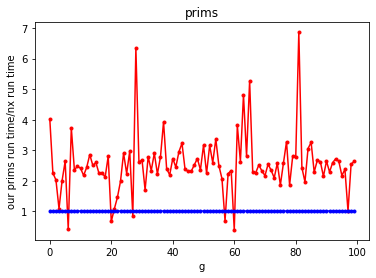

In [285]:
#check running time between our prims implementation and nx's implementation
prims_comp = CompareImplementation(
            implementation_object=Prims_NX,
            generator=UniqueWeightsGraph_Generator(min_n=10, max_n=30, min_p=0.2,
                                max_p=0.5, weighted=True, directed=False,
                                is_connected=True),
            x_partial='partial(impl.mst)',
            y_partial='partial(nx.minimum_spanning_tree, g, "weight", "prim")',
            experiment_name='prims',
            n_trials=100
)
prims_comp.run_experiment()


100%|██████████| 100/100 [03:53<00:00,  2.33s/it]


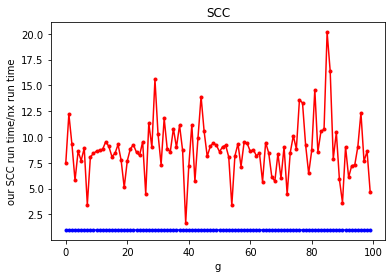

In [316]:
"""
For SCC and topologicalSort, for comparison purposes we convert the generators into lists, so that it's a more 
fair comparison with my implementation (which returns the complete results in one go). When compared to the 
native nx functions that return the generators my function is suddenly 20,000X slower :'D, so these numbers
make more sense!
"""
def nx_scc_list(g):
        return tuple(nx.kosaraju_strongly_connected_components(g))

scc_comp = CompareImplementation(
        implementation_object=SCC_NX,
        generator=RandomGraph_Generator(min_n=10, max_n=30, min_p=0.2, max_p=0.3, weighted=False,
                                directed=True),
        x_partial="""partial(impl.StronglyConnectedComponents)""",
        y_partial="""partial(nx_scc_list, g)""",
        experiment_name='SCC',
        n_trials=1000
).run_experiment()

100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


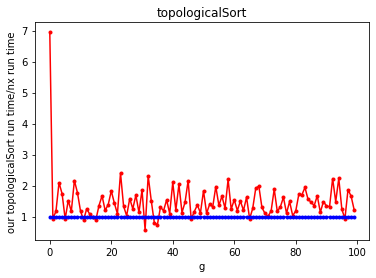

In [317]:
def nx_topologicalSort_list(g):
        return tuple(nx.topological_sort(g))

ts_comp = CompareImplementation(
        implementation_object=TopologicalSort_NX,
        generator=DAG_Generator(min_n=10, max_n=30),
        x_partial="""partial(impl.topologicalSort)""",
        y_partial="""partial(nx_topologicalSort_list, g)""",
        experiment_name='topologicalSort',
        n_trials=1000
).run_experiment()

In [297]:
"""
9. Draw a dependency graph illustrating the steps needed to send an email. Perform a topological sort on your graph.
"""
email = nx.MultiDiGraph()
email.add_edges_from([
    ('account login', 'create new email'),
    ('prepare attachments', 'add attachments'),
    ('create new email', 'add recipient'),
    ('create new email', "add cc's",),
    ('create new email', 'draft content'),
    ('create new email', 'add attachments'),
    ("add cc's", 'finalize draft'),
    ('draft content', 'finalize draft'),
    ('add recipient', 'finalize draft'),
    ('add attachments', 'finalize draft'),
    ('finalize draft', 'send'),
])

visualise_nx_graph(email, directed=True, graph_name='email_dependencies.html', show_edge_weights=False)

email_ts = TopologicalSort_NX(email)
print(email_ts.topologicalSort())

['prepare attachments', 'account login', 'create new email', 'add attachments', 'draft content', "add cc's", 'add recipient', 'finalize draft', 'send']


In [322]:
"""
10. Derive an expression for the base of the exponent used in expressing the running time of the knights tour.
- basically express k as a function of the board size 
"""

def gen_moves(pos):
    moves = [(-2, 1), 
            (2, 1),
            (2, -1),
            (1, -2),
            (-1, 2),
            (-1, -2),
            (-2, -1),
            (1, 2)]
    return [(pos[0] + move[0], pos[1] + move[1]) for move in moves]

def check_legal(pos, board_size):
    if (pos[0] < 0 or pos[0] > board_size-1) or (pos[1] < 0 or pos[1] > board_size-1):
        return False 
    else:
        return True 

def generate_board(board_size):
    return np.zeros((board_size, board_size))

def generate_moves_board(board_size):
    board = generate_board(board_size)
    for row in range(board_size):
        for col in range(board_size):
            count = 0
            moves = gen_moves((row, col))
            for move in moves:
                if check_legal(move, board_size):
                    count += 1
            board[row][col] = count
    return board 



In [362]:
for b in range(3, 12):
    print(np.unique(generate_moves_board(b), return_counts=True), f'board size: {b}')

(array([0., 2.]), array([1, 8])) board size: 3
(array([2., 3., 4.]), array([4, 8, 4])) board size: 4
(array([2., 3., 4., 6., 8.]), array([4, 8, 8, 4, 1])) board size: 5
(array([2., 3., 4., 6., 8.]), array([ 4,  8, 12,  8,  4])) board size: 6
(array([2., 3., 4., 6., 8.]), array([ 4,  8, 16, 12,  9])) board size: 7
(array([2., 3., 4., 6., 8.]), array([ 4,  8, 20, 16, 16])) board size: 8
(array([2., 3., 4., 6., 8.]), array([ 4,  8, 24, 20, 25])) board size: 9
(array([2., 3., 4., 6., 8.]), array([ 4,  8, 28, 24, 36])) board size: 10
(array([2., 3., 4., 6., 8.]), array([ 4,  8, 32, 28, 49])) board size: 11


(Let $b = Boardsize$)
If we look at the distribution of the different types of cells within the move boards starting from $b=4$, we can observe a few things:
(Each cell type's number corresponds to the number of legal moves that could be made from there)
1. Constant number of 2-cells - 4 Corners
2. Constant number of 3-cells - 8 positions adjacent to each corner
3. Frequency of 4-cells change as a function of board size -  $4*(b-3)$
4. Frequency of 6-cells change as a function of board size -  $4*(b-4)$
5. Frequency of 8-cells change as a function of board size -  $(b-4)^2$
 
Because $k$ is just the sum of the moves board divided by the number of cells, we simply need to sum the individual terms and divide by 
$b^2$:

$k = \frac{(4*2) + (3*8) + (4*4(b-3)) + (6*4(b-4)) + 8*(b-4)^2}{b^2}$

expanded:

$k = \frac{32 + 16b - 48 + 24b - 96 + 8 * (b^2 - 8b + 16)}{b^2}$

simplified:

$k = \frac{8(b^2 - 3b + 2)}{b^2}$ , $b \ge 1$

Interestingly, the equation extends to $ b < 4 $, bit unexpected xD, because I set out to 
simplify the problem by just considering $ b \ge 4$. But nice!

In [372]:
#test out the equation we obtained 
for b in tqdm(range(1, 101)):
    ans = np.average(generate_moves_board(b))
    res = (8*(b**2 - 3*b + 2))/b**2
    assert ans == res

100%|██████████| 100/100 [00:03<00:00, 31.73it/s]


11. Explain why the general DFS algorithm is not suitable for solving the knights tour problem.


The general DFS algorithm is not suitable for solving the knights tour problem because in the knights tour problem because the idea of DFS is that it's a search algorithm, and it aims to search the entire graph 
until some value is found, or just when the whole graph is traversed. This means **ALL** possible trees are searched until the end (ie. when we hit a leaf node). In the case of knights tour, even if earlier in the tree a condition has been
violated (in this problem, it would be if it explores a node that we've already visited
before in the current path.), general DFS will still finish exploring the tree. This is wildly inefficient, as the number of nodes grow exponentially as the board size increases, and as most trees will violate the constraints, we are doing a lot of extra work. DFS with backtracking makes more sense in this problem, as we can move on for a tree if we know that it's a dead end (ie. violates a condition) (process of popping nodes from path and resetting node colour). This is essentially DFS with **PRUNING**. 

Also, because we are building all the possible trees within general DFS, recovery of the valid trees can be difficult. As we aren't keeping track of valid paths as we do in the backtracking algorithm, at the end of DFS we would have to examine the final layer nodes one-by-one, trace predecessors to obtain the path, and check if the paths are valid along the way. Because the number of nodes grows exponentially, there will be a lot of final layer nodes to examine, which introduces another inefficiency.

12. What is the Big-O running time for Prim’s minimum spanning tree algorithm?

(I use dequeue interchangeably with del-min operation for priority queues because I'm lazy)

The Big-O running time for the textbook's implementation of 
Prim's MST is $O(n^2)$. The reason for this is because at the beginning of 
the algorithm all the vertices are loaded onto the priority queue. In the main toop
each vertex is at least visited once as they are removed from the queue, and 
at each vertex, we get its neighbours and check if they are still in the priority queue to see if the priority 
needs to be changed. This ```in``` operation is worse case $O(n)$ (we just search the _heap list
to see if the key exists there), which makes it the main loop $O(n^2)$, where $n$ is the number of vertices. 

From Wiki:
<br><br>
Wiki states that if we go with the edges route and store all edges within a binary heap, this can lead to worst case $O(|E|log|E|)$ running time. Here |E|log|E| simply describes the time complexity in the operation where we are dequeuing edges from the 
priority queue for consideration. But once we obtain the min edge, we would still need to check if the current nodes exists in the current tree,
which be a $O(E*V)$ operation? (for every edge, we have to check if at least one of source or target is not in the tree
before we decide to add it, so in any case it's at least one pass through the current working tree.) I suppose that term might've been omitted because we only consider the dominant term within big-O.

Also, in wiki it states that prim's mst with binary heap and adjacency list's time complexity can be 
$O((|V| + |E|) log(|V|))$. I think the difference between our's and the textbook's implementation can sort of explain this.

In our implementation, $|V|log|V|$ comes from dequeue operation for each vertex, which is the same as the textbook.
Within the while loop, for each vertex we look at its neighbours, and go into update_priority. Because prim's looks
at undirected graphs, it means we will eventually look at 2|E| edges (examined from both sides.) Within
update priority, we don't check if a node is ```in``` pq as in the textbook. Instead, we check if the min_weight is still
infinity, and either insert it into the priority queue or change its priority, and both operations' big-O is $O(log(|V|))$.
So for this part of the while loop the time complexity is $O(2|E|log(|V|))$ or $O(|E|log(|V|))$.
so adding everything, we get $O((|V| + |E|) log(|V|))$

But technically speaking as the graph gets denser $E$ approaches $V^2$, so, I suppose it depends on what representation you'd like it to be.


## Programming Exercises

1. Modify the depth first search function to produce a topological sort.

Implemented above in TopologicalSort_NX - main difference is just saving nodes as they finish into finish order and returning
the reversed of that

2. Modify the depth first search to produce strongly connected components.

Implemented above in SCC_NX - mainly just running dfs twice. First time on the normal graph, and a second time 
on the transposed graph, where in the main loop nodes are visited in the order of the nodes returned by topologicalSort.
In the main loop, everytime we encounter an unvisited node, we deem that as a the beginning of a new component tree. Each
component tree is extended within the nested dfsVisit calls.


3. Write the transpose method for the Graph class.

Implemented above in SCC_NX - just reversing all edges and creating a new graph.

In [377]:
"""
4. Using breadth first search write an algorithm that can determine the shortest path from each vertex to every other vertex. 
This is called the all pairs shortest path problem.
"""


'\n4. Using breadth first search write an algorithm that can determine the shortest path from each vertex to every other vertex. \nThis is called the all pairs shortest path problem.\n'